# imports and loading DataFrame

In [517]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import datetime


# fact table
sessions_df = pd.read_json("data/sessions.jsonl", lines=True)

# dimension tables
deliveries_df = pd.read_json("data/deliveries.jsonl", lines=True)
products_df = pd.read_json("data/products.jsonl", lines=True)
users_df = pd.read_json("data/users.jsonl", lines=True)

# constant values

In [518]:
MAKE_PLOTS = True
MAKE_PAIRPLOT = True
DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"
PRICE_TRESHOLD = 100_000    # for outliers
WEIGHT_TRESHOLD = 50        # for outliers
COLUMNS_TO_DROP = ["delivery_timestamp", "session_id", "purchase_id", "event_type", "name", "street", "product_id", "product_name", "brand", "user_id"]
COLUMNS_TO_ONE_HOT = ["delivery_company", "city", "category_path"]
SEED = 42

# merging all data into one Datafram and other transformations

## adding a column with time difference in deliveries
adding a column with time difference between purchase_timestamp and delivery_timestamp in deliveries table

1. Cut microseconds from delivery_timestamp, so it will be the same format as purchase_timestamp, because there are no microseconds in purchase_timestamp (using "." as a separator).
2. Change columns format to datetime
3. Add time_diff column (as timedelta64 object).
4. Drop rows where time_diff is null (which means that delivery_timestamp was null).
5. Change type of time_diff from timedelta64 to seconds in float.
6. Drop rows where time_diff is below 0. THIS STEP IS MADE IN ### without time_diff below 0

In [519]:
# 1.
deliveries_df["delivery_timestamp"] = deliveries_df["delivery_timestamp"].str.split('.', expand=True)[0]

# 2.
deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format=DATE_FORMAT)
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format=DATE_FORMAT)

# 3.
deliveries_df["time_diff"] = deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"]

# 4.
deliveries_df = deliveries_df[deliveries_df["time_diff"].notna()]

# 5.
# time diff as duration in seconds
deliveries_df["time_diff"] = deliveries_df["time_diff"].apply(datetime.timedelta.total_seconds)

# 6.
# deliveries_df = deliveries_df[deliveries_df["time_diff"] >= 0]

## join deliveries with sessions

In [520]:
# drop rows where event_type is not equal "BUY_PRODUCT"
sessions_df = sessions_df[sessions_df["event_type"] == "BUY_PRODUCT"]
df = deliveries_df.merge(sessions_df, on="purchase_id", how="left")

In [521]:
# making sure, that timestamp == purchase_timestamp
num_of_rows_before = df.shape[0]
df = df[df["timestamp"] == df["purchase_timestamp"]]
num_of_rows_after = df.shape[0]

assert(num_of_rows_before == num_of_rows_after)

# now we can drop timestamp column, as it is redundant
df = df.drop(columns="timestamp")

## join with other tables

In [522]:
df = df.merge(users_df, on="user_id", how="left")
df = df.merge(products_df, on="product_id", how="left")

# missing data analysis - MCAR, MAR, MNAR

made without outliers but with prices below zero (on copy of df)

In [523]:
missing_data_df = df.copy(deep=False)
missing_data_df["delivery_company_is_missing"] = missing_data_df["delivery_company"].isna()
missing_data_df["user_id_is_missing"] = missing_data_df["user_id"].isna()
missing_data_df["product_id_is_missing"] = missing_data_df["product_id"].isna()

In [524]:
# rejecting outliers for given PRICE_TRESHOLD
missing_data_df = missing_data_df[missing_data_df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
missing_data_df = missing_data_df[missing_data_df["weight_kg"] <= WEIGHT_TRESHOLD]

In [525]:
NUM_BINS_MISSING = 50

def compare_histograms_for_missing(input_df1, input_df2, end_of_title1="", end_of_title2=""):
    fig, ax = plt.subplots(4, 2)
    
    def plot_histograms_missing(input_df, plot_column, end_of_title=""):

        def plot_hist_missing(x, y, col_name, num_bins=None):
            if num_bins:
                ax[x, y].hist(input_df[col_name], bins=num_bins)
            else:
                ax[x, y].hist(input_df[col_name])
            ax[x, y].set_title(f"histogram of {col_name}" + end_of_title)
            ax[x, y].set_xlabel(col_name)
            ax[x, y].set_ylabel("# of observations")

        plot_hist_missing(0, plot_column, "time_diff", NUM_BINS_MISSING)
        plot_hist_missing(1, plot_column, "offered_discount", NUM_BINS_MISSING)
        plot_hist_missing(2, plot_column, "price", NUM_BINS_MISSING)
        plot_hist_missing(3, plot_column, "weight_kg", NUM_BINS_MISSING)

    plot_histograms_missing(input_df1, 0, end_of_title1)
    plot_histograms_missing(input_df2, 1, end_of_title2)

    fig.set_size_inches([24, 21])
    plt.show()

## delivery_company missing

In [526]:
no_missing_delivery_company = missing_data_df[missing_data_df["delivery_company_is_missing"] == False]
missing_delivery_company = missing_data_df[missing_data_df["delivery_company_is_missing"] == True]

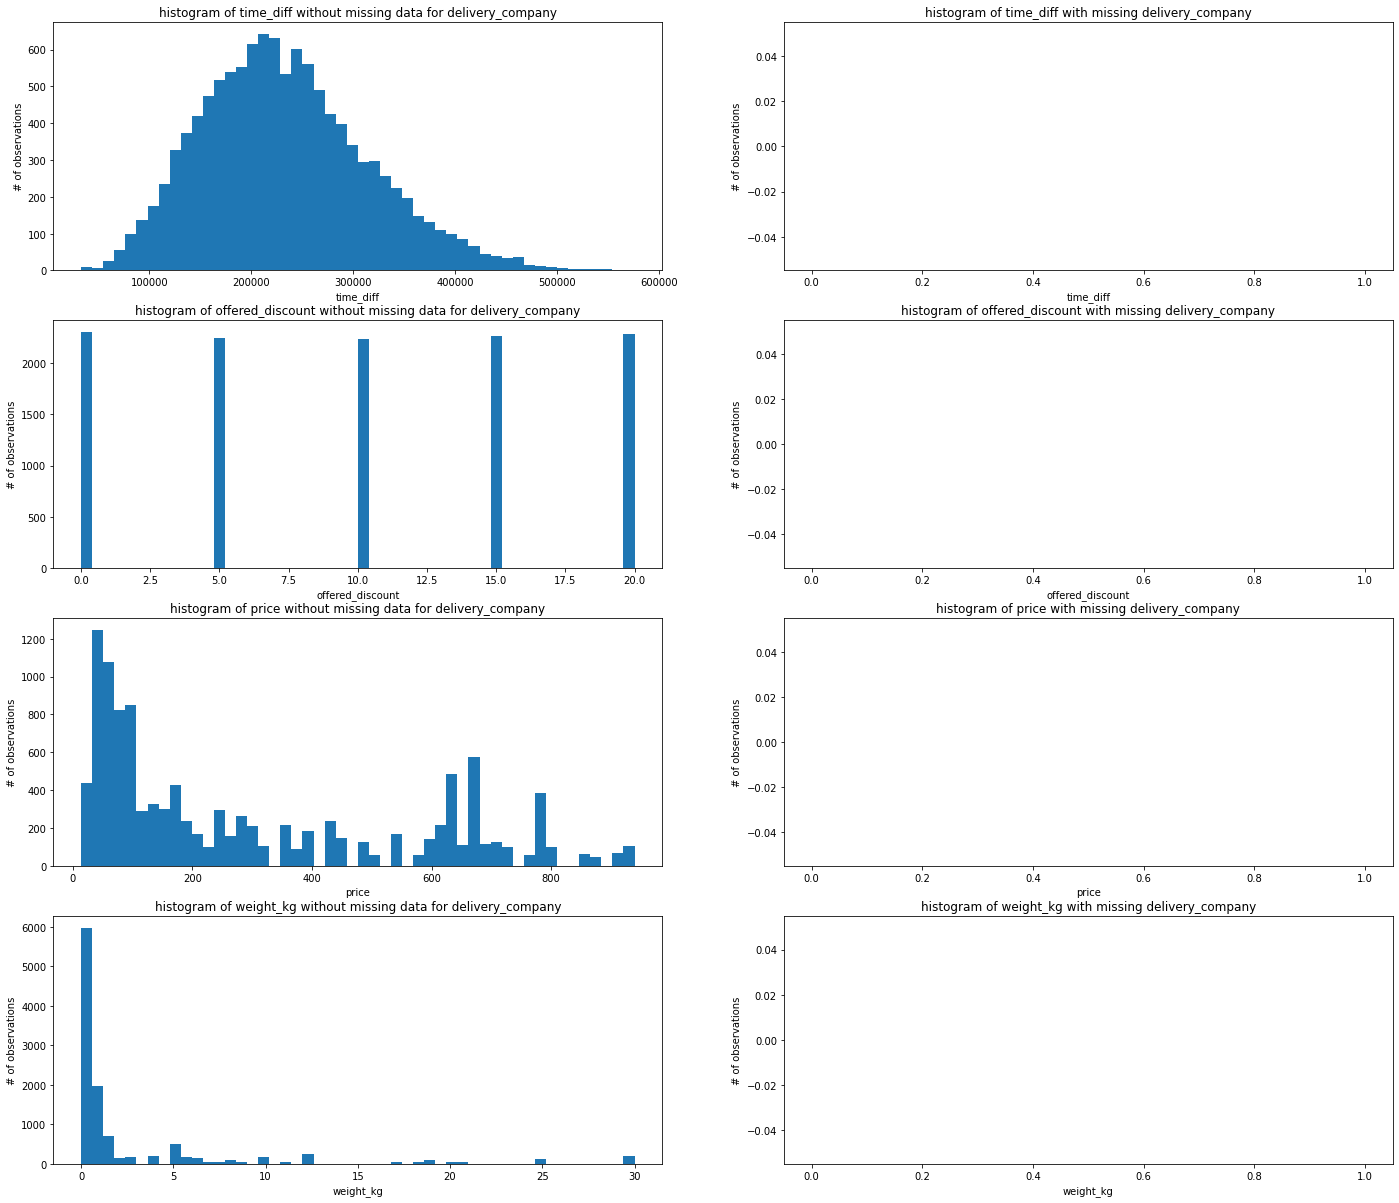

In [527]:
if MAKE_PLOTS:
    compare_histograms_for_missing(no_missing_delivery_company, missing_delivery_company, " without missing data for delivery_company", " with missing delivery_company")

## user_id missing

In [528]:
no_missing_user_id = missing_data_df[missing_data_df["user_id_is_missing"] == False]
missing_user_id = missing_data_df[missing_data_df["user_id_is_missing"] == True]

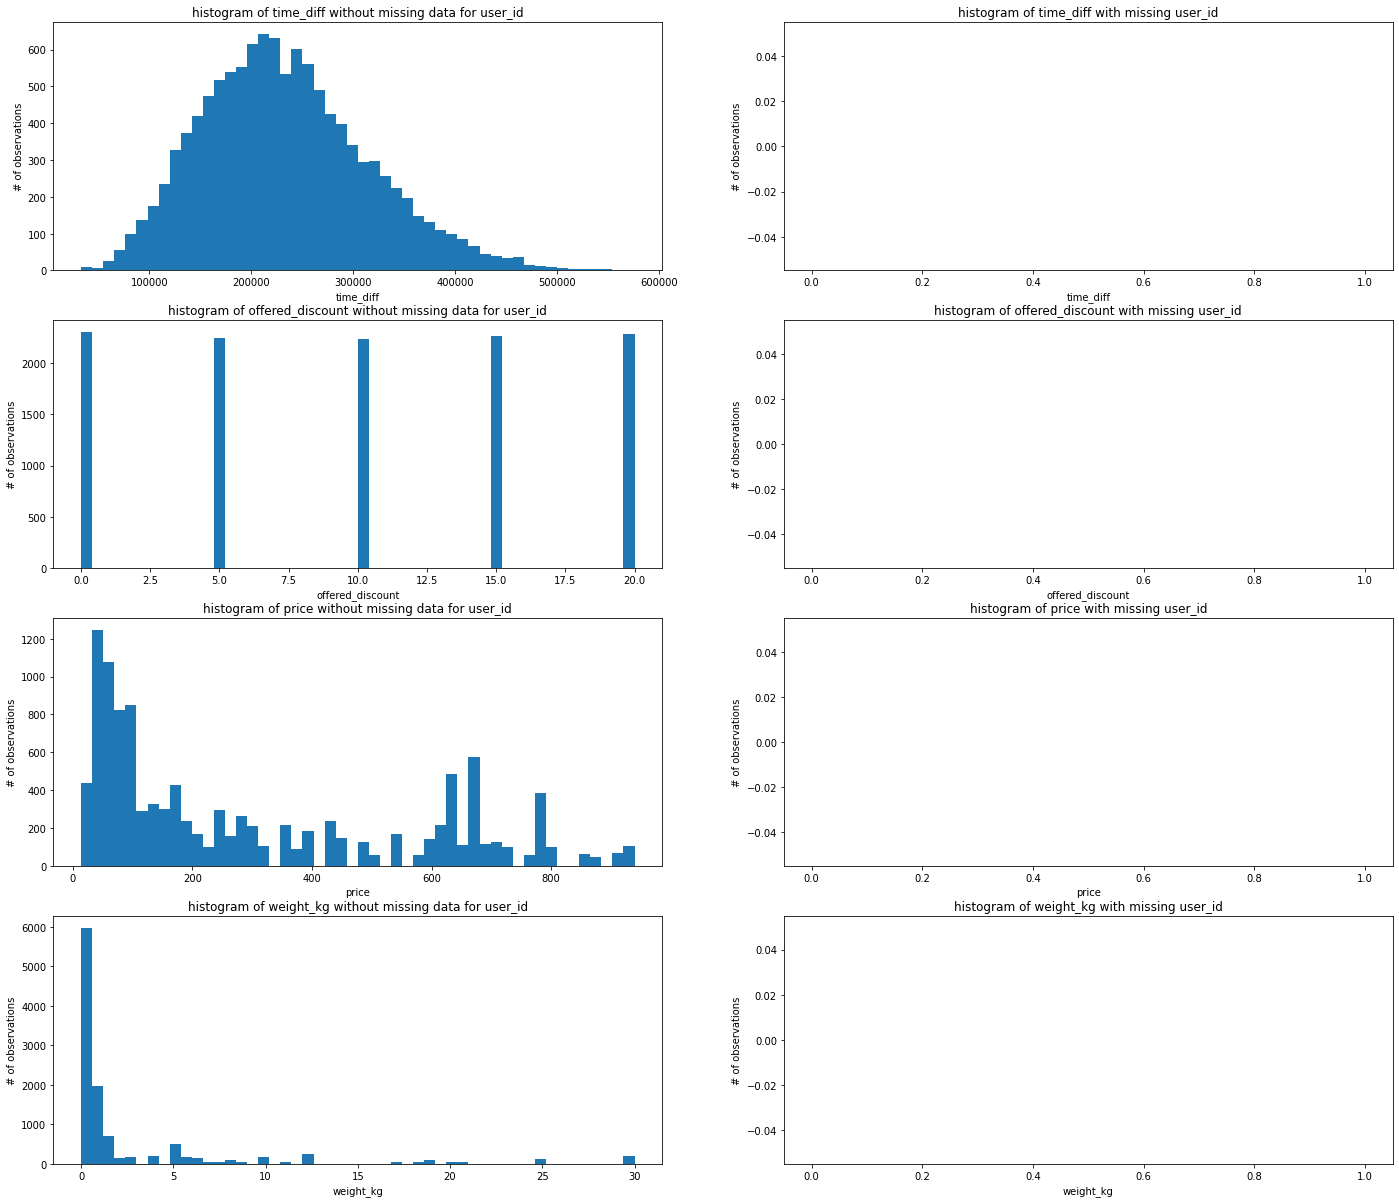

In [529]:
if MAKE_PLOTS:
    compare_histograms_for_missing(no_missing_user_id, missing_user_id, " without missing data for user_id", " with missing user_id")

## product_id missing
this analysis doesn't make sense

In [530]:
no_missing_product_id = missing_data_df[missing_data_df["product_id_is_missing"] == False]
missing_product_id = missing_data_df[missing_data_df["product_id_is_missing"] == True]

In [531]:
# if MAKE_PLOTS:
#     compare_histograms_for_missing(no_missing_product_id, missing_product_id, " without missing data for product_id", " with missing product_id")

# visualizations

## time_diff histogram and log-normal distribution test

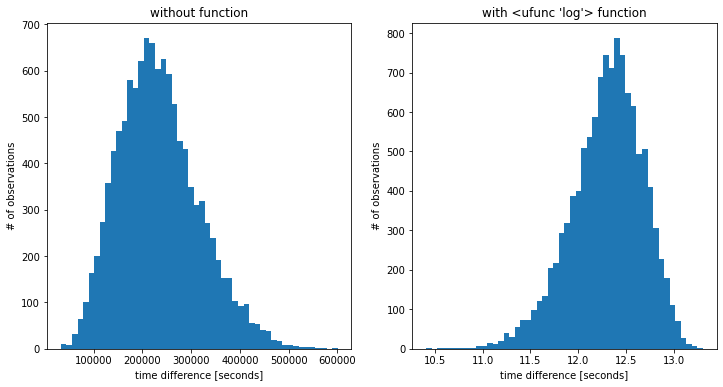

In [532]:
if MAKE_PLOTS:
    fig, ax = plt.subplots(1, 2)

    def plot_hist(x, num_bins=50, func=None):
        if func:
            ax[x].hist(func(df["time_diff"]), bins=num_bins)
            ax[x].set_title(f"with {func} function")
        else:
            ax[x].hist(df["time_diff"], bins=num_bins)
            ax[x].set_title(f"without function")
        ax[x].set_xlabel("time difference [seconds]")
        ax[x].set_ylabel("# of observations")

    plot_hist(0)
    plot_hist(1, func=np.log)
    # plot_hist(1, 0, func=np.log2)
    # plot_hist(1, 1, func=np.log10)

    fig.set_size_inches([12, 6])
    plt.show()

## histograms of continuous variables

In [533]:
NUM_BINS = 50


def plot_histograms(input_df):
    fig, ax = plt.subplots(2, 2)

    def plot_hist(x, y, col_name, num_bins=None):
        if num_bins:
            ax[x, y].hist(input_df[col_name], bins=num_bins)
        else:
            ax[x, y].hist(input_df[col_name])
        ax[x, y].set_title(f"histogram of {col_name}")
        ax[x, y].set_xlabel(col_name)
        ax[x, y].set_ylabel("# of observations")

    plot_hist(0, 0, "time_diff", NUM_BINS)
    plot_hist(0, 1, "offered_discount", NUM_BINS)
    plot_hist(1, 0, "price", NUM_BINS)
    plot_hist(1, 1, "weight_kg", NUM_BINS)

    fig.set_size_inches([12, 12])
    plt.show()

### with outliers

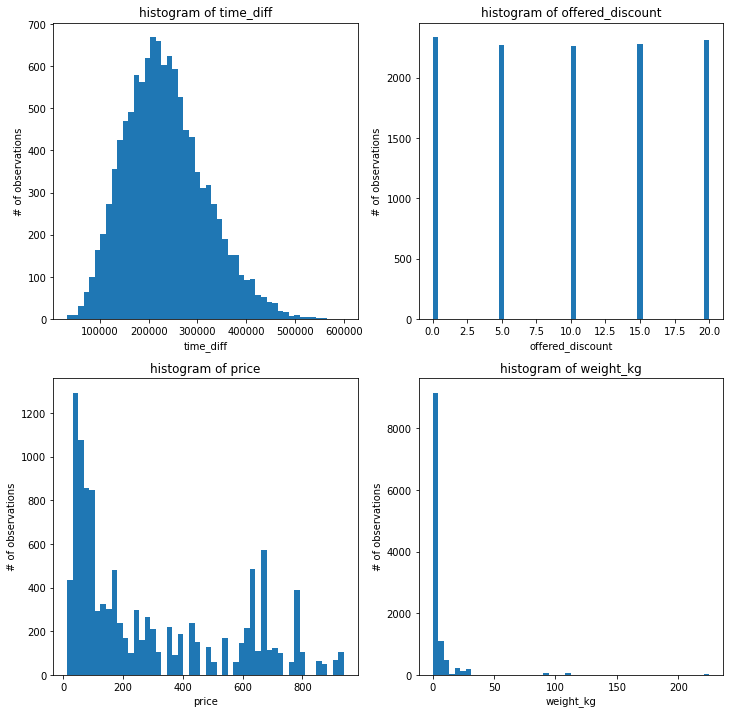

In [534]:
if MAKE_PLOTS:
    plot_histograms(df)

### without outliers

In [535]:
# rejecting outliers for given PRICE_TRESHOLD
df = df[df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
df = df[df["weight_kg"] <= WEIGHT_TRESHOLD]

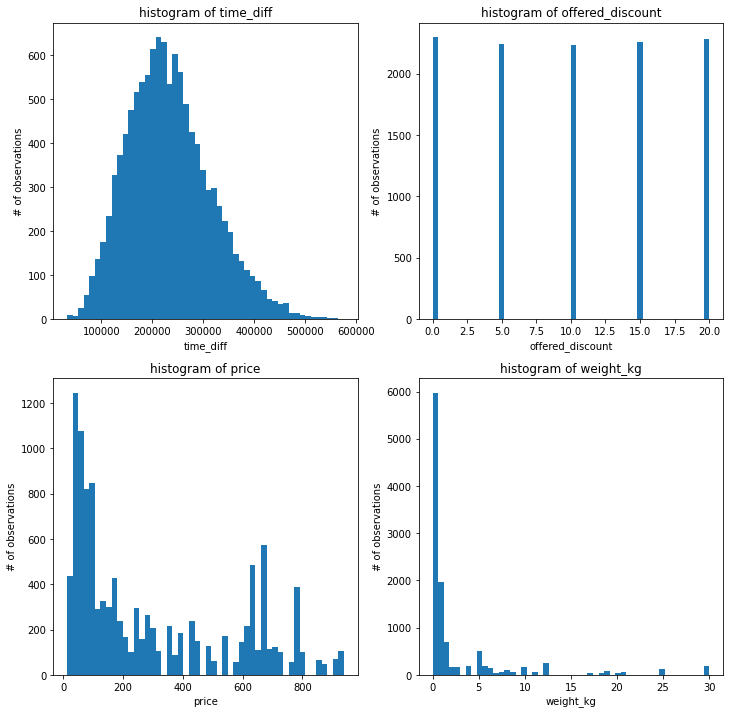

In [536]:
if MAKE_PLOTS:
    plot_histograms(df)

### without prices below 0

In [537]:
# deleting rows with prices below 0
df = df[df["price"] >= 0]

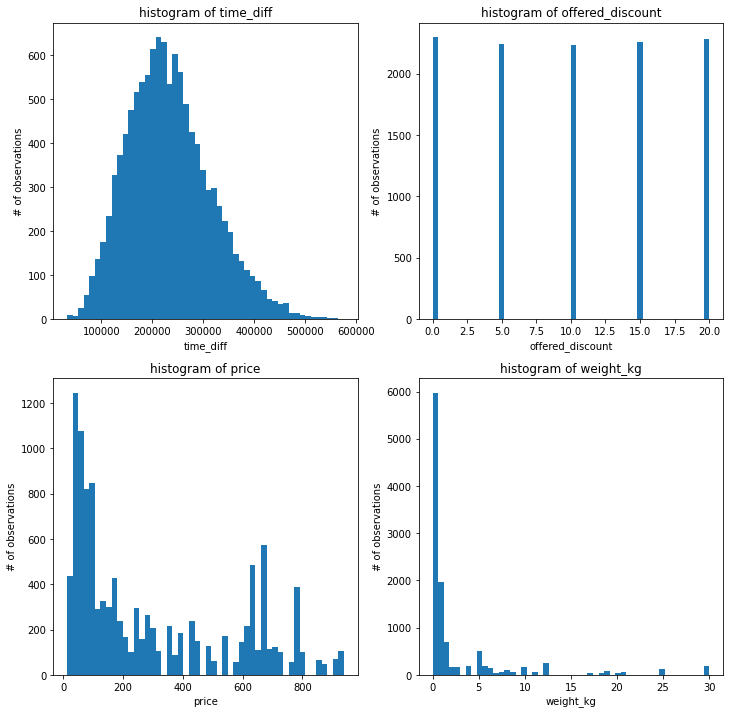

In [538]:
if MAKE_PLOTS:
    plot_histograms(df)

### without time_diff below 0

In [539]:
df_with_time_diff_below_0 = df
df = df[df["time_diff"] >= 0]

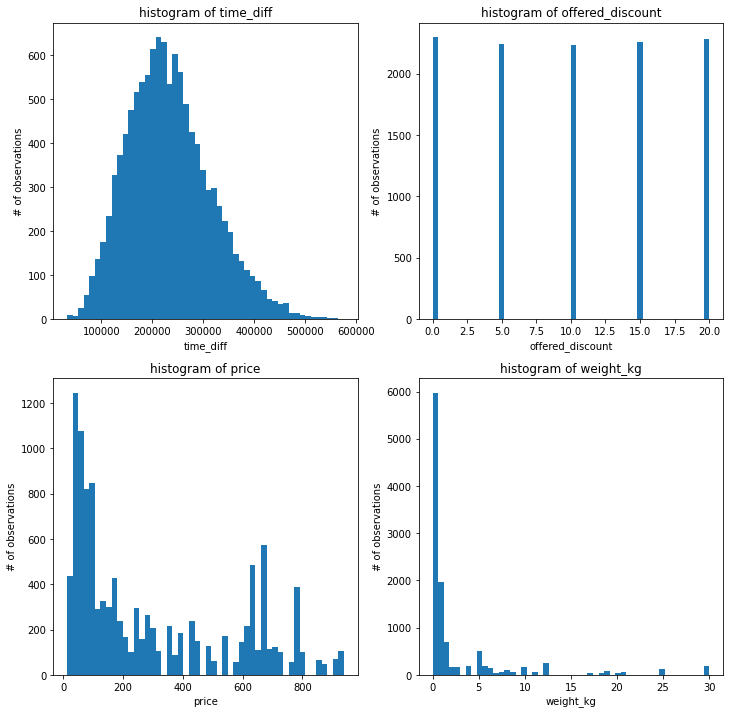

In [540]:
if MAKE_PLOTS:
    plot_histograms(df)

## heatmap

### with time_diff below zero

In [541]:
def update_list_of_columns():
    banned_list_of_columns = ["purchase_id", "delivery_company", "session_id", "user_id", "product_id"]
    columns_list = [col for col in df.columns.values.tolist() if col not in banned_list_of_columns]
    return columns_list

columns_list = update_list_of_columns()

(11315, 19)


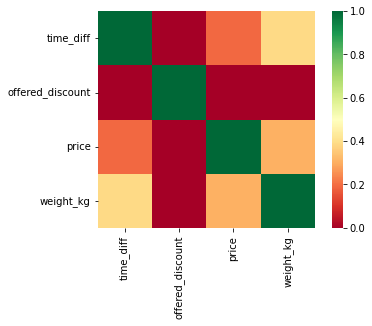

In [542]:
if MAKE_PLOTS:
    print(df_with_time_diff_below_0.shape)
    ax = sns.heatmap(df_with_time_diff_below_0[columns_list].corr(), square=True, cmap='RdYlGn')

### without time_diff below zero

#### pearson

(11315, 19)


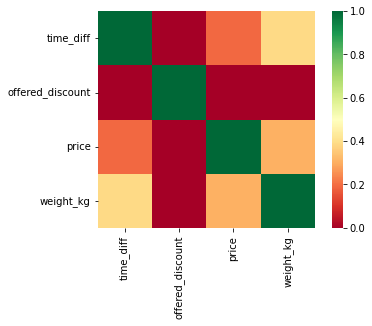

In [543]:
if MAKE_PLOTS:
    print(df.shape)
    ax = sns.heatmap(df[columns_list].corr('pearson'), square=True, cmap='RdYlGn')

#### spearman

(11315, 19)


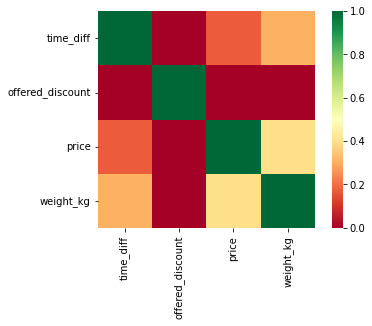

In [544]:
if MAKE_PLOTS:
    print(df.shape)
    ax = sns.heatmap(df[columns_list].corr('spearman'), square=True, cmap='RdYlGn')

#### kendall

In [545]:
# if MAKE_PLOTS:
#     print(df.shape)
#     ax = sns.heatmap(df[columns_list].corr('kendall'), square=True, cmap='RdYlGn')

## Pairplot

In [546]:
df.isnull().values.any()

False

In [547]:
df_temp = df.drop(columns='optional_attributes')
df_temp.nunique().sort_values()

event_type                1
delivery_company          3
offered_discount          5
city                      7
category_path            23
brand                    57
weight_kg               105
price                   133
product_name            159
product_id              161
name                    396
street                  396
user_id                 396
time_diff             11092
delivery_timestamp    11289
purchase_timestamp    11314
session_id            11315
purchase_id           11315
dtype: int64

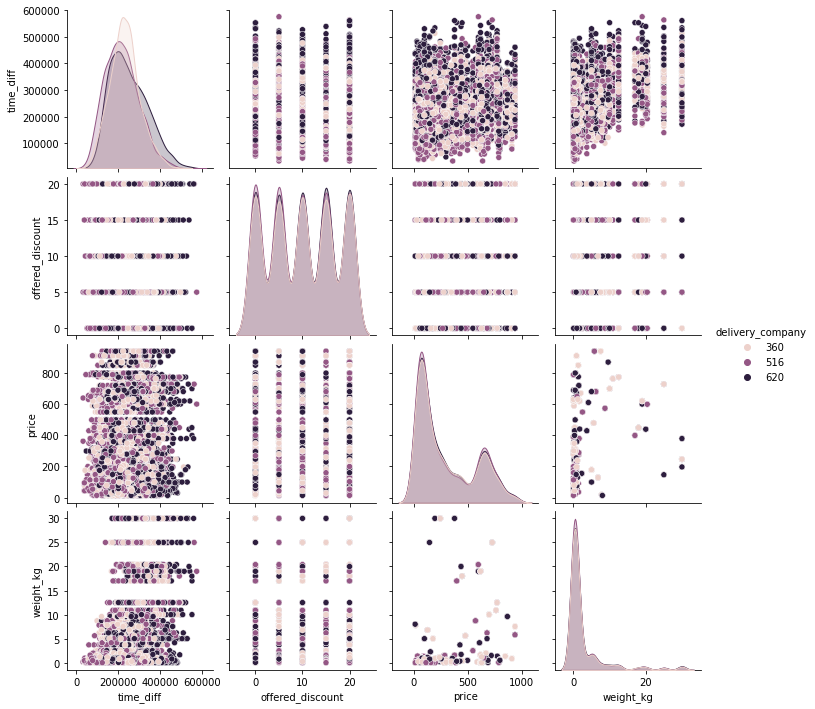

In [548]:
if MAKE_PLOTS and MAKE_PAIRPLOT:
    columns_to_drop_for_pairplot = ['purchase_id', 'session_id', 'user_id', 'product_id']
    df_for_pairplot = df.drop(columns=columns_to_drop_for_pairplot)
    g = sns.pairplot(df_for_pairplot, kind='scatter', hue='delivery_company')

Na pierwszy rzut oka atrybut delivery_company nie ma tak dużego znaczenia - spodziewaliśmy się większego zróżnicowania.

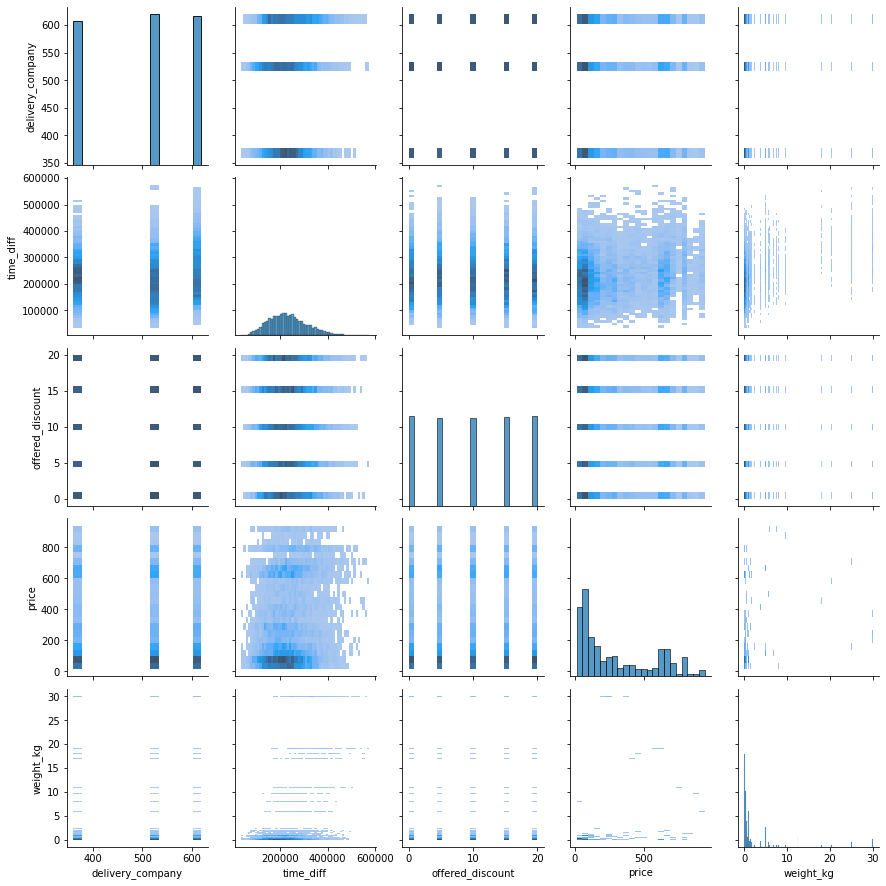

In [549]:
if MAKE_PLOTS and MAKE_PAIRPLOT:
    columns_to_drop_for_pairplot = ['purchase_id', 'session_id', 'user_id', 'product_id']
    df_for_pairplot = df.drop(columns=columns_to_drop_for_pairplot)
    g = sns.pairplot(df_for_pairplot, kind='hist')

# dropping columns (choosing attributes)

In [550]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11315 entries, 0 to 11451
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   purchase_id          11315 non-null  int64         
 1   purchase_timestamp   11315 non-null  datetime64[ns]
 2   delivery_timestamp   11315 non-null  datetime64[ns]
 3   delivery_company     11315 non-null  int64         
 4   time_diff            11315 non-null  float64       
 5   session_id           11315 non-null  int64         
 6   user_id              11315 non-null  int64         
 7   product_id           11315 non-null  int64         
 8   event_type           11315 non-null  object        
 9   offered_discount     11315 non-null  int64         
 10  name                 11315 non-null  object        
 11  city                 11315 non-null  object        
 12  street               11315 non-null  object        
 13  product_name         11315 non-

In [551]:
# drop columns
df = df.drop(columns=COLUMNS_TO_DROP)
df = df.drop(columns="optional_attributes") # chyba do zmiany - wysokosc itp.
df = df.drop(columns="purchase_timestamp") # na pewno do zmiany

In [552]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11315 entries, 0 to 11451
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   delivery_company  11315 non-null  int64  
 1   time_diff         11315 non-null  float64
 2   offered_discount  11315 non-null  int64  
 3   city              11315 non-null  object 
 4   category_path     11315 non-null  object 
 5   price             11315 non-null  float64
 6   weight_kg         11315 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 965.2+ KB


# one-hot encoding

In [553]:
# df.to_excel("data_before_one_hot_encoding.xlsx")

In [554]:
def one_hot_encode_a_col_in_pd(df, col_name):
    one_hot = pd.get_dummies(df[col_name])
    df = df.drop(columns=col_name)
    df = df.join(one_hot)
    return df

In [555]:
for col_name in COLUMNS_TO_ONE_HOT:
    df = one_hot_encode_a_col_in_pd(df, col_name)

#### checking df shape

In [556]:
print(df.shape)
columns_list = update_list_of_columns()
# ax = sns.heatmap(df[columns_list].corr(), square=True, cmap='RdYlGn')

(11315, 37)


In [557]:
df = df.dropna()
print(df.shape)
# one-hot encoding took care of missing data, so shape has not changed

(11315, 37)


In [558]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11315 entries, 0 to 11451
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   time_diff                                      11315 non-null  float64
 1   offered_discount                               11315 non-null  int64  
 2   price                                          11315 non-null  float64
 3   weight_kg                                      11315 non-null  float64
 4   360                                            11315 non-null  uint8  
 5   516                                            11315 non-null  uint8  
 6   620                                            11315 non-null  uint8  
 7   Gdynia                                         11315 non-null  uint8  
 8   Kraków                                         11315 non-null  uint8  
 9   Poznań                                         113

# normalization

In [559]:
# specify columns for standardization scaling (Z-score normalization)
cols_to_std = []

# specify columns for min-max scaling
cols_to_min_max = ['offered_discount', 'price', 'weight_kg']

In [560]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for col in cols_to_std:
    x = df[col].values
    std_scaler = StandardScaler()
    x_scaled = std_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

for col in cols_to_min_max:
    x = df[col].values
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

# test of linear regression models

In [561]:
df.head()

,time_diff,offered_discount,price,weight_kg,360,516,620,Gdynia,Kraków,Poznań,...,Myszki;Przewodowe,Pamięci przenośne;Pendrive,Podzespoły komputerowe;Pamięć RAM,Skanery;Profesjonalne,Skanery;Płaskie USB,Tablety;Urządzenia,Urządzenia VR;Gogle VR,Urządzenia wskazujące;Pady,Zestaw klawiatura i mysz;Bezprzewodowe,Zestaw klawiatura i mysz;Przewodowe
0,194397.0,0.75,0.228930,0.020000,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,184285.0,0.50,0.406238,0.000800,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,164705.0,0.00,0.665416,0.000000,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,252885.0,0.75,0.448400,0.010667,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,228672.0,0.25,0.032173,0.008667,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [562]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def split_data(df, target_column="time_diff"):
    y = df["time_diff"].to_numpy()
    X = df.drop(columns="time_diff")
    return train_test_split(X, y, test_size=0.2, random_state=SEED)

In [563]:
def train_models(models_list):
    for model in models_list:
        model.fit(X_train, y_train)
    return models_list

In [564]:
def create_df_with_predictions(models_list, y_test):
    y_pred_df = pd.DataFrame()
    y_pred_df["y_test"] = y_test
    for model in models_list:
        y_pred_df[f"{type(model).__name__} prediction"] = model.predict(X_test)
    return y_pred_df

In [565]:
def display_predictions(y_pred_df):
    display(y_pred_df.head())
    display(y_pred_df.info())
    display(y_pred_df.describe())

In [566]:
def print_scores(models_list):
    for model in models_list:
        score = model.score(X_test, y_test)
        print(f"{type(model).__name__} score = {score}")

In [567]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = split_data(df)

models_list = [Ridge(alpha=0.1),
               Lasso(alpha=0.1),
               DecisionTreeRegressor(random_state=SEED),
               RandomForestRegressor(random_state=SEED)]
models_list = train_models(models_list)

y_pred_df = create_df_with_predictions(models_list, y_test)
display_predictions(y_pred_df)

print_scores(models_list)


C:\Users\Milosz\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Milosz\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Milosz\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.250e+11, tolerance: 6.140e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\Milosz\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: Futur

,y_test,Ridge prediction,Lasso prediction,DecisionTreeRegressor prediction,RandomForestRegressor prediction
0,225013.0,290099.397627,290102.502202,234756.000000,240422.535833
1,170068.0,224589.803889,224587.601688,218666.333333,218057.028683
2,195038.0,220195.254557,220183.593309,209810.000000,224411.356167
3,279415.0,218721.321280,218678.110036,217214.000000,255187.185000
4,331221.0,314672.878256,314675.818996,293167.000000,323641.094000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   y_test                            2263 non-null   float64
 1   Ridge prediction                  2263 non-null   float64
 2   Lasso prediction                  2263 non-null   float64
 3   DecisionTreeRegressor prediction  2263 non-null   float64
 4   RandomForestRegressor prediction  2263 non-null   float64
dtypes: float64(5)
memory usage: 88.5 KB


None

,y_test,Ridge prediction,Lasso prediction,DecisionTreeRegressor prediction,RandomForestRegressor prediction
count,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000
mean,231077.817941,231590.309590,231590.612588,231306.667372,232500.027738
std,79705.119199,63143.210879,63153.272847,76873.903500,70647.209831
min,33091.000000,118774.742931,118772.470091,49657.000000,80814.375548
25%,174344.000000,179479.707112,179468.661751,175737.333333,181582.363048
50%,222482.000000,226798.094311,226799.552363,225506.571429,229581.471250
75%,281067.000000,282137.470001,282160.523263,276351.000000,272063.701024
max,535390.000000,455954.397472,456027.135749,542877.000000,511299.210333


Ridge score = 0.6105116585468076
Lasso score = 0.6105251957707455
DecisionTreeRegressor score = 0.4056608429158278
RandomForestRegressor score = 0.5888508788910269


C:\Users\Milosz\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Milosz\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Milosz\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Milosz\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str'